# Color Detection 

In this notebook I want to download custom files from a google search and use a pre-trained model to get the correct color of each picture

In [91]:
import urllib.request
import csv

import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets

Idea from: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb

Download into file
Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press CtrlShiftj on Windows/Linux and CmdOptj on macOS, and a small window the javascript 'Console' will appear. In Firefox press CtrlShiftk on Windows/Linux or CmdOptk on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [2]:
# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [3]:
def dl_img(url, file_path, file_name):
    full_path = file_path + file_name + '.jpg'
    urllib.request.urlretrieve(url, full_path)

For each color (in my case: blue, red, green, yellow and black) change the color. Make it for both train and testset.

In [4]:
%cd data/train

C:\Users\lasse\kaggleProjects\Farberkennung\data\train


In [5]:
%ls

 Datenträger in Laufwerk C: ist Windows
 Volumeseriennummer: 2432-0233

 Verzeichnis von C:\Users\lasse\kaggleProjects\Farberkennung\data\train

10.04.2020  19:50    <DIR>          .
10.04.2020  19:50    <DIR>          ..
10.04.2020  18:35    <DIR>          black
10.04.2020  18:24    <DIR>          blue
10.04.2020  18:33    <DIR>          green
10.04.2020  18:31    <DIR>          red
10.04.2020  18:34    <DIR>          yellow
               0 Datei(en),              0 Bytes
               7 Verzeichnis(se), 489.882.759.168 Bytes frei


In [6]:
%cd ../..

C:\Users\lasse\kaggleProjects\Farberkennung


In [7]:
color = 'yellow'
folder = 'test'

In [ ]:
with open(f'{color}_test.csv') as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if len(row)>0:
            file_name = f'{color}_{line_count}'
            url = listToString(row)
            dl_img(url, f'data/{folder}/{color}/', file_name)
            line_count = line_count + 1


## Prepare data

In [8]:
# Get the available device

if torch.cuda.is_available():
    dev = "cuda:0"  # Gpu
else:
    dev = "cpu"
device = torch.device(dev)

device

device(type='cpu')

I also want to show the image name so I override the getitem function fro the ImageFolder Class

In [9]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [10]:
transform = transforms.Compose(
    [transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


trainset = ImageFolderWithPaths(root="C:/Users/lasse/kaggleProjects/Farberkennung/data/train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = ImageFolderWithPaths(root="C:/Users/lasse/kaggleProjects/Farberkennung/data/test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=False)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(trainset),
    "test": len(testset)
}
CLASSES = list(trainset.class_to_idx.keys())

In [11]:
CLASSES

['black', 'blue', 'green', 'red', 'yellow']

In [12]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

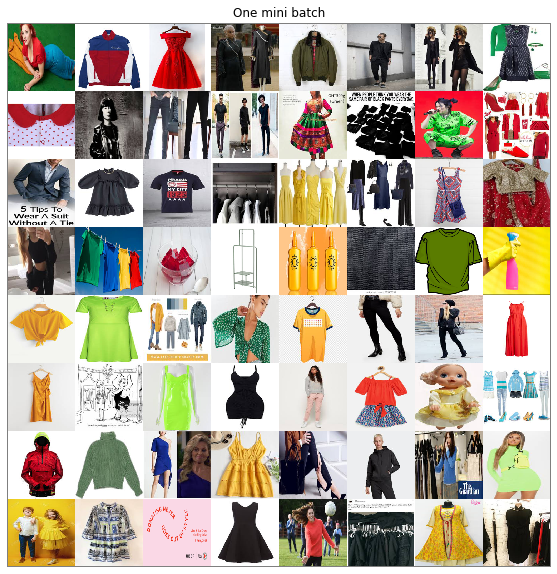

In [13]:
dataiter = iter(trainloader)
images, labels, path = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [14]:
path[:5]

('C:/Users/lasse/kaggleProjects/Farberkennung/data/train/red\\red_163.jpg',
 'C:/Users/lasse/kaggleProjects/Farberkennung/data/train/red\\red_51.jpg',
 'C:/Users/lasse/kaggleProjects/Farberkennung/data/train/red\\red_24.jpg',
 'C:/Users/lasse/kaggleProjects/Farberkennung/data/train/black\\black_129.jpg',
 'C:/Users/lasse/kaggleProjects/Farberkennung/data/train/green\\green_55.jpg')

## Load ResNet18

In [15]:
model_ft = models.resnet18(pretrained=True)

# turn training false for all layers, other than fc layer
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(CLASSES))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.003, momentum=0.9)
exp_lr_sc = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Check the ResNet18 model architecture

In [16]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0 
            
            # Iterate over data
            for inputs, labels, path in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                path = path
                
                # Zero the parametsrs
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / datasizes[phase]
            epoch_acc = running_corrects.double()/datasizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            if(phase == "test" and epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print("Training complete in {:0f}m {:0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best val Acc: {}:4f".format(best_acc))
    
    # load best model parameters
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model_path = 'saved_models/model_ft.pth'   # add path of trained model

if model_path is None:
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_sc, epochs=12)
else:
    model_ft.load_state_dict(torch.load(model_path))

In [42]:
def imshowaxis(ax, img, orig, pred, path):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(f'original label: {orig}' + "\n" + f'predicted label: {pred}' + "\n" + f'path: ' + path, color="red", fontsize=24)
    else:
        ax.set_title(f'original label: {orig}' + "\n" + f'predicted label: {pred}' + "\n" + f'path: ' + path, fontsize=24)
    ax.axis("off")


def vis_model(model, num_images=50):
    was_training = model.training
    model.eval()
    
    images_so_far = 0
    figure, ax = plt.subplots(5, 3, figsize=(30, 60))
    
    
    with torch.no_grad():
        for i , (inputs, labels, path) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            path = path
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(5):
                for j in range(3):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]], path[images_so_far].split('\\')[1] )
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)

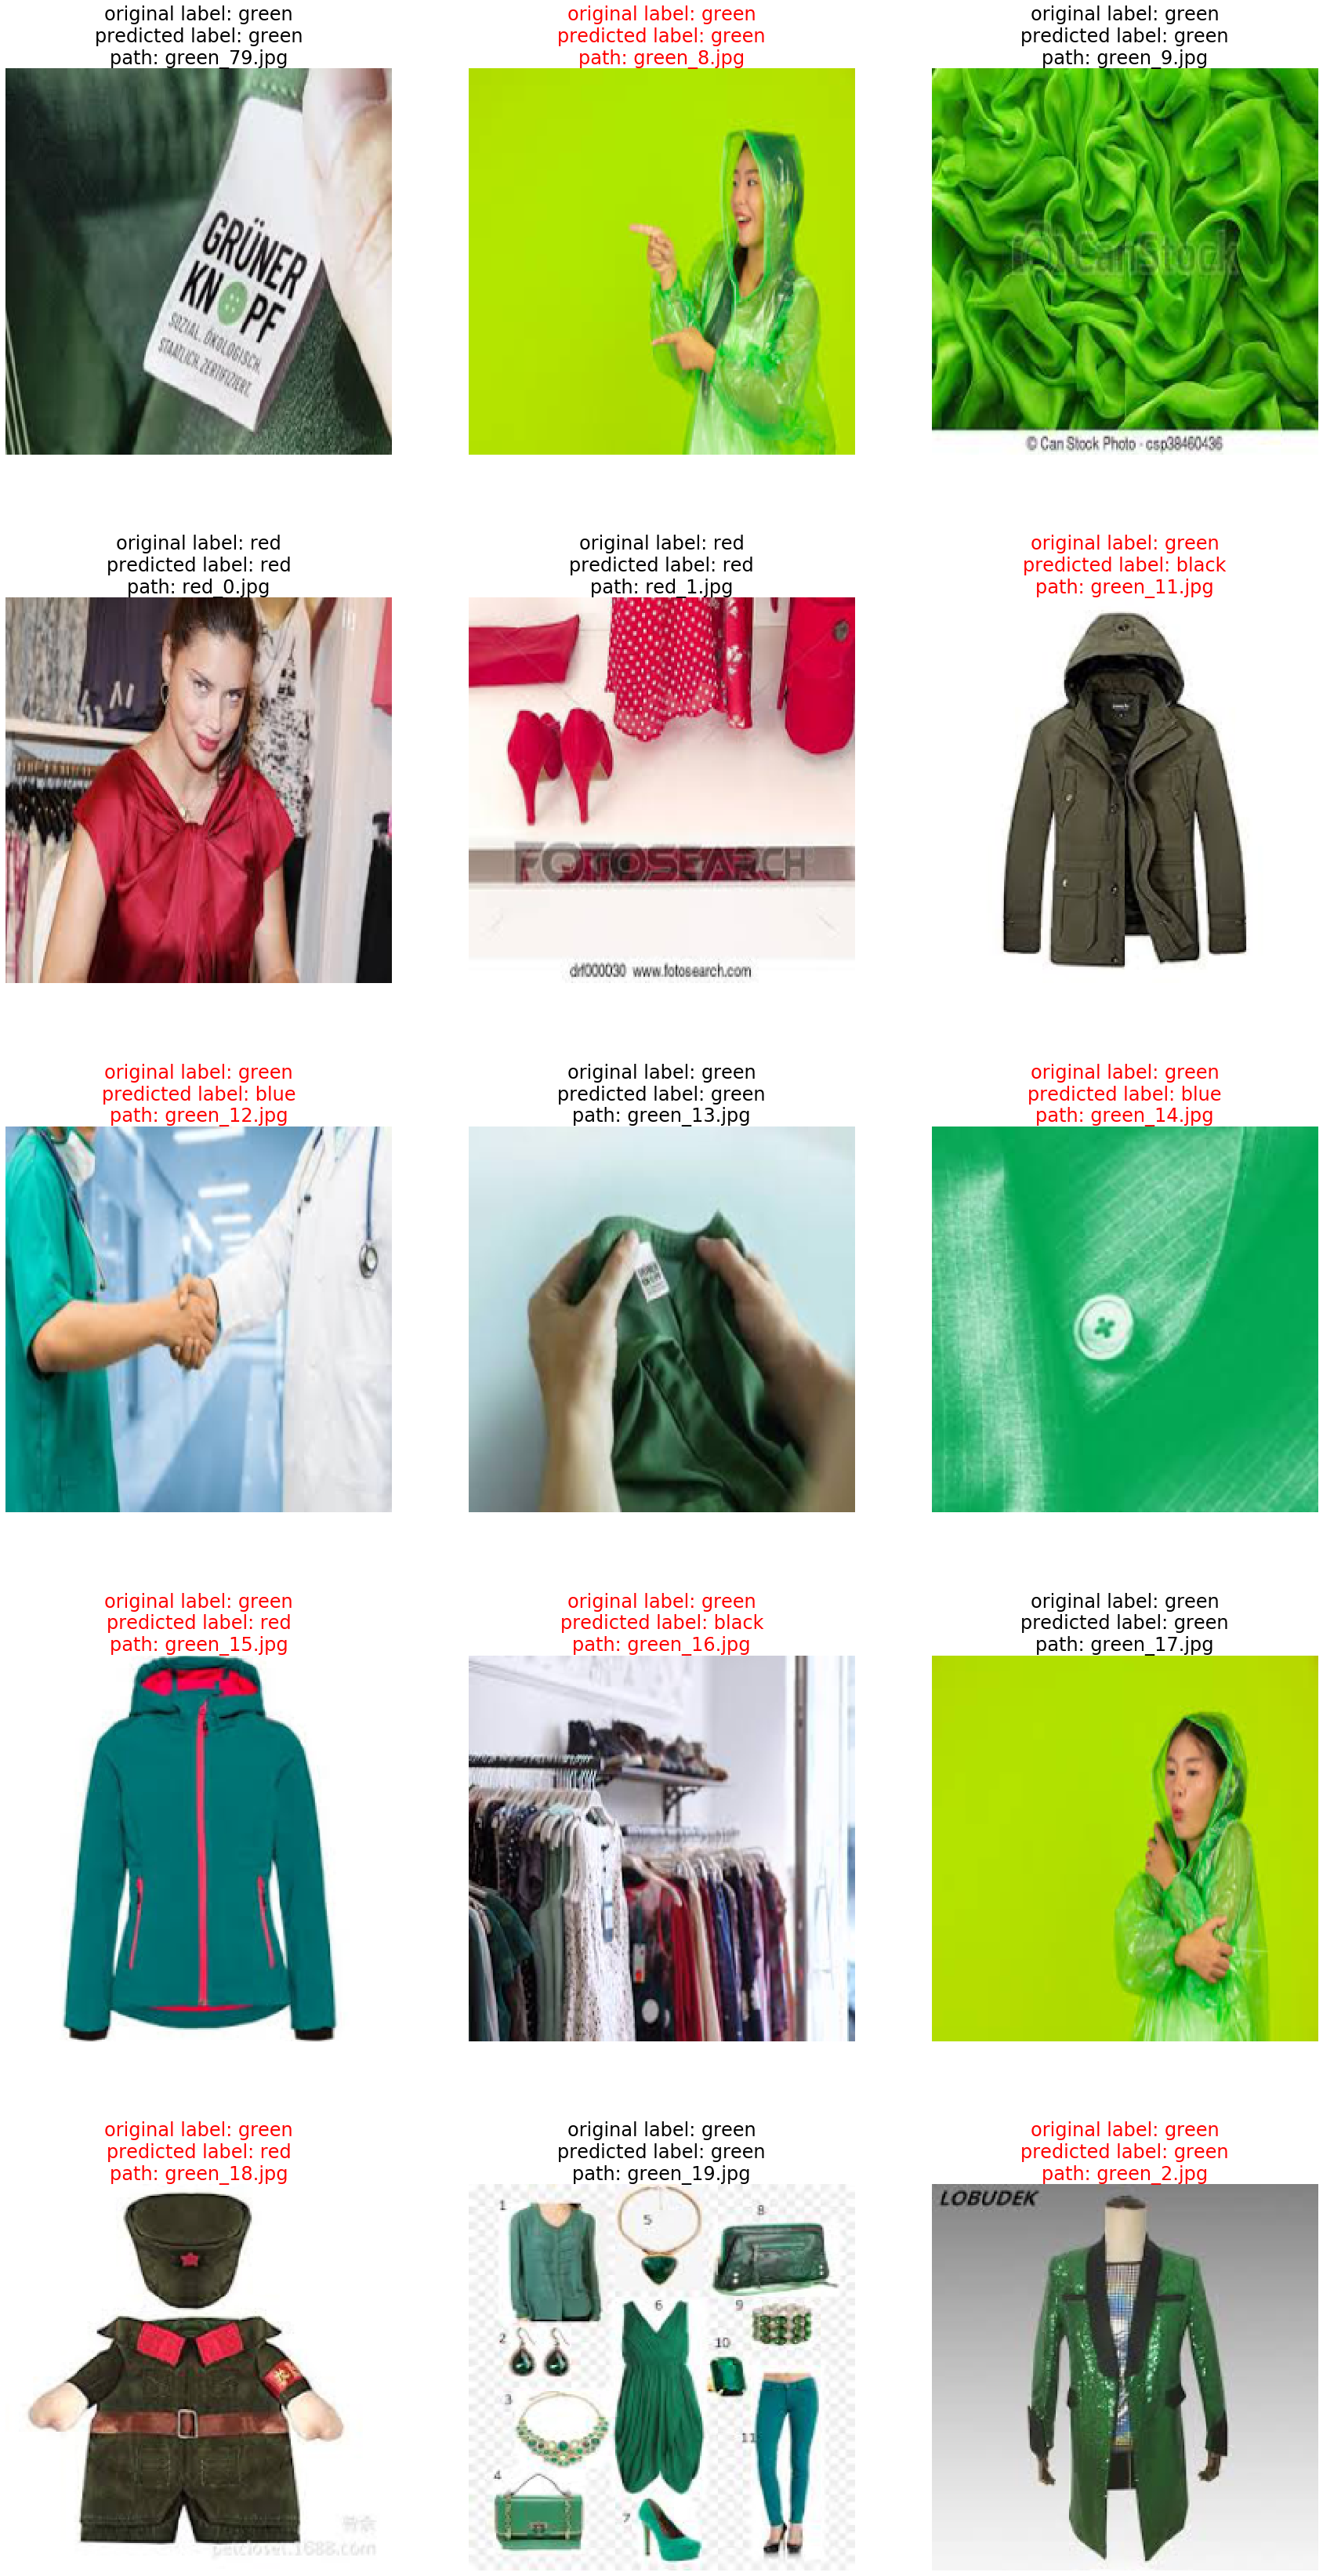

In [43]:
# Title: Original vs Predicted 
vis_model(model_ft)

In [ ]:
torch.save(model_ft.state_dict(), 'saved_models/model_ft.pth')

## We can use our trained model to find out wrongly labeled data and delete it

Our dataset is not checked yet, there might be pictures, where the labels are wrong. We want to find out where our model struggles, so from each batch we pull the 10 pictures with the lowest probability of the predicted label.

To make the output a probability we use the softmax

In [77]:
was_training = model_ft.training

m = nn.Softmax(dim=1)


with torch.no_grad():
        
        for i , (inputs, labels, path) in enumerate(dataloaders["test"]):
            print(i)
            if i==0:
                inputs = inputs.to(device)
                labels = labels.to(device)
                path = path
                outputs = m(model_ft(inputs)) # to get the probabilities of each color
                probs, preds = torch.max(outputs, 1)
                prob_order = torch.argsort(probs)[:10]
                path_cat = list( path[i] for i in prob_order )
                probs_least_prob_cat = outputs[prob_order]
                preds_least_prob_cat = preds[prob_order]
                img_least_prob_cat = inputs[prob_order]
                labels_least_prob_cat = labels[prob_order]
            elif i>0:
                inputs = inputs.to(device)
                labels = labels.to(device)
                path = path
                outputs = m(model_ft(inputs)) # to get the probabilities of each color
                probs, preds = torch.max(outputs, 1)
                prob_order = torch.argsort(probs)[:10]
                # concatenate the probs, preds, images, and labels of the 10 lowest probabilities in each batch
                path_cat = path_cat + list( path[z] for z in prob_order )
                probs_least_prob_cat = torch.cat((probs_least_prob_cat, outputs[prob_order]),0)
                preds_least_prob_cat = torch.cat((preds_least_prob_cat, preds[prob_order]),0)
                img_least_prob_cat = torch.cat((img_least_prob_cat, inputs[prob_order]),0)
                labels_least_prob_cat = torch.cat((labels_least_prob_cat, labels[prob_order]),0)
                
        # get the 10 images with the lowest probability
        probs, preds = torch.max(probs_least_prob_cat, 1)
        prob_order_ = torch.argsort(probs)[:10]
        path_ = list( path_cat[z] for z in prob_order_ )
        probs_least_prob_ = probs_least_prob_cat[prob_order_]
        preds_least_prob_ = preds_least_prob_cat[prob_order_]
        img_least_prob_ = img_least_prob_cat[prob_order_]
        labels_least_prob_ = labels_least_prob_cat[prob_order_]

0
1
2
3
4
5
6


We now get the probs/preds/images/labels of those images, where our model is unsure

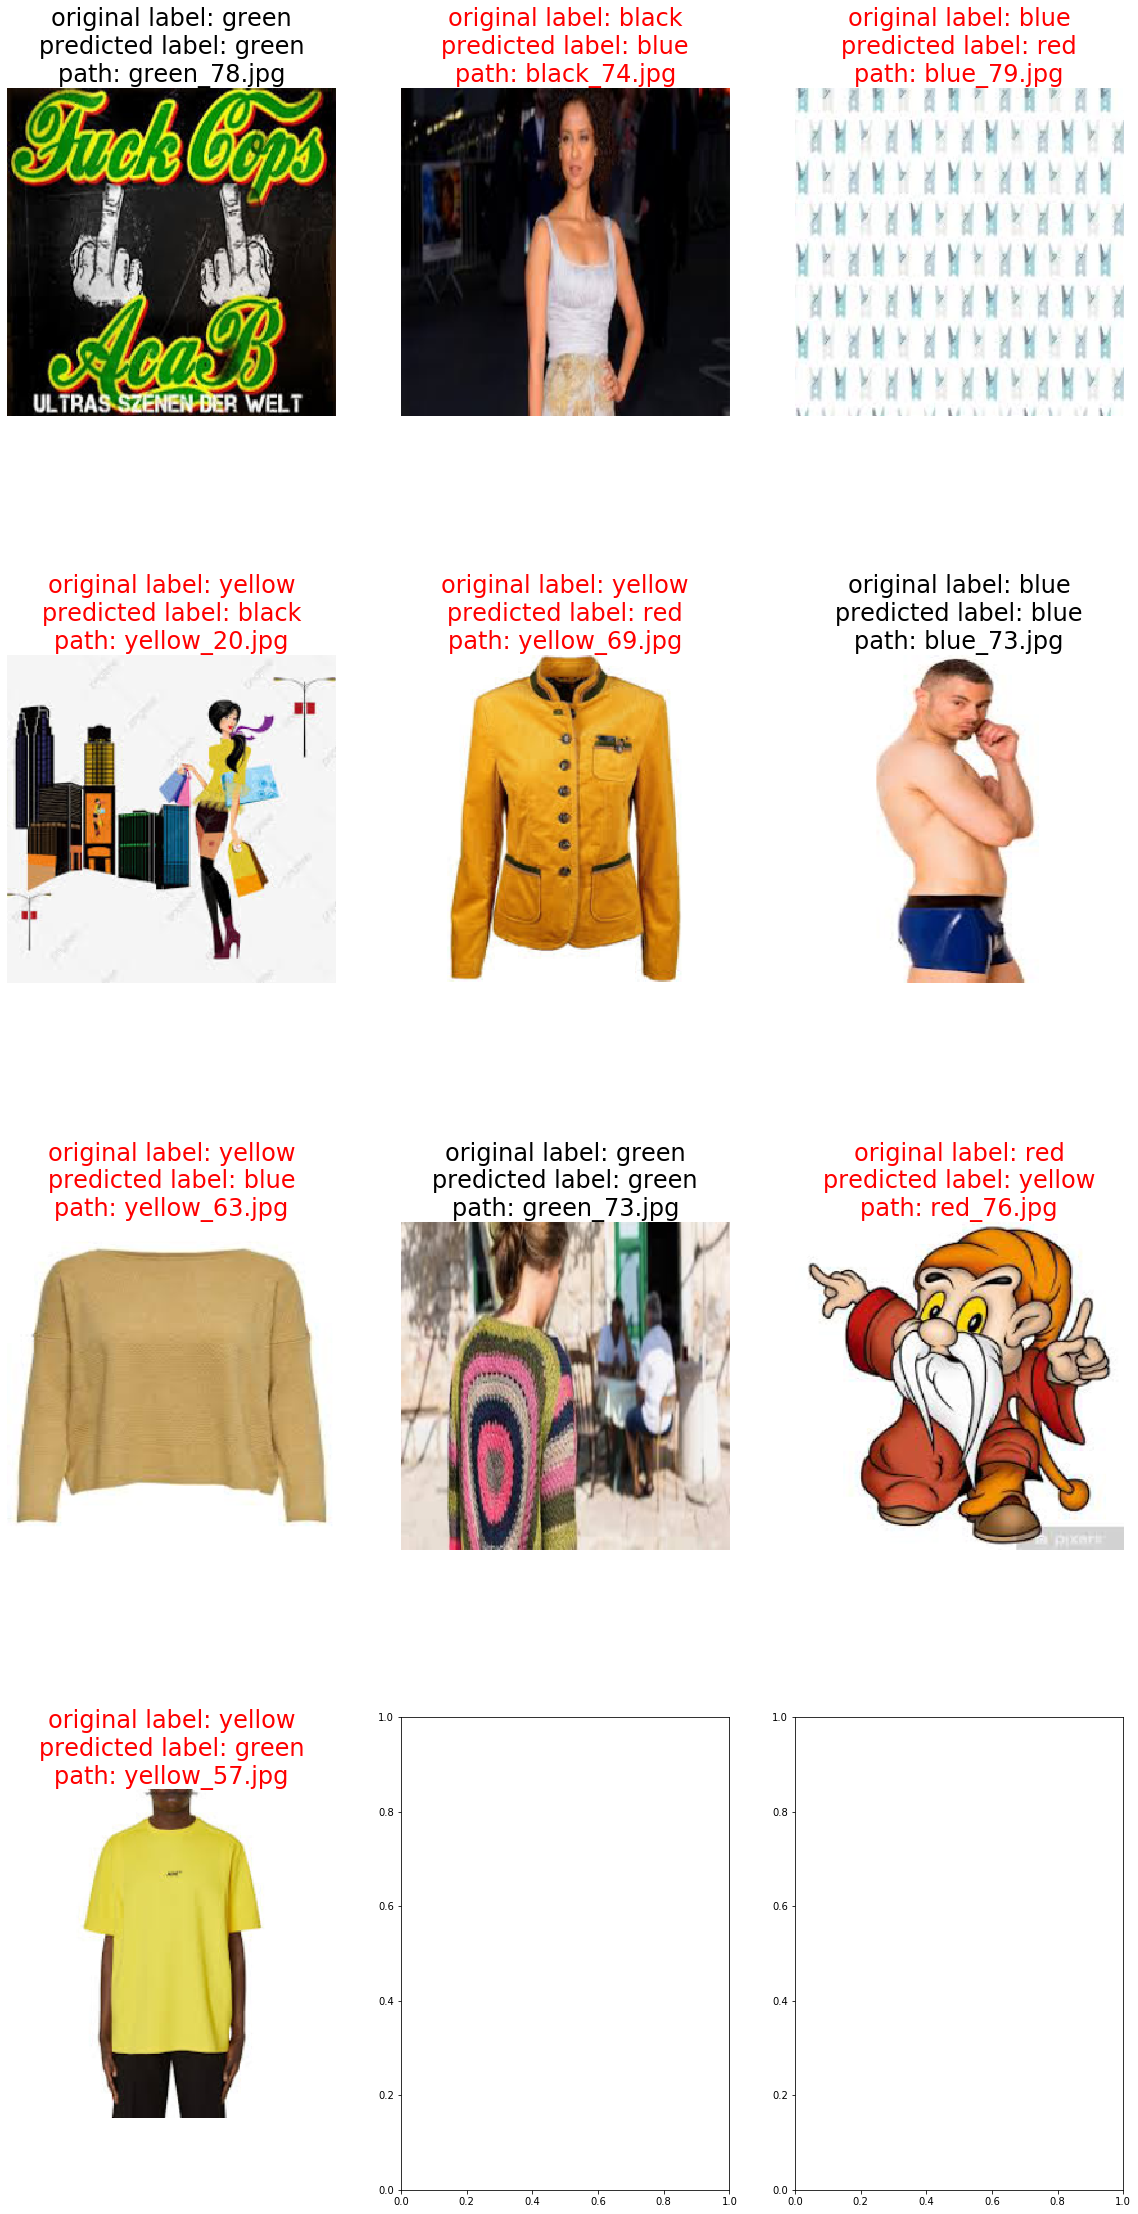

In [80]:
images_so_far = 0
num_images = 10 # batch_size is 64
figure, ax = plt.subplots(4, 3, figsize=(20, 40))


for i in range(4):
    for j in range(3):
        if images_so_far < num_images:
                    imshowaxis(ax[i][j], img_least_prob_.cpu().data[images_so_far], CLASSES[labels_least_prob_[images_so_far]], CLASSES[preds_least_prob_[images_so_far]], path_[images_so_far].split('\\')[1] )
                    images_so_far += 1
        else:
            pass

And indeed, some of these Inputs seem pretty wrong

We can use the path to simply delete them in bash: let's say we decided to delete image 0,1,2,3,5,7,8

In [92]:
images_to_delete = list( path_[z] for z in [0,1,2,3,5,7,8] )
images_to_delete[0]

'C:/Users/lasse/kaggleProjects/Farberkennung/data/test/green\\green_78.jpg'

In [93]:
if os.path.exists(images_to_delete[0]):
    os.remove(images_to_delete[0])
else:
    print("The file does not exist")

In [96]:
for i in range(0,len(images_to_delete)):
    if os.path.exists(images_to_delete[i]):
        os.remove(images_to_delete[i])
    else:
        print(images_to_delete[i] + ": This file does not exist")

C:/Users/lasse/kaggleProjects/Farberkennung/data/test/green\green_78.jpg: This file does not exist
C:/Users/lasse/kaggleProjects/Farberkennung/data/test/black\black_74.jpg: This file does not exist
C:/Users/lasse/kaggleProjects/Farberkennung/data/test/blue\blue_79.jpg: This file does not exist
C:/Users/lasse/kaggleProjects/Farberkennung/data/test/yellow\yellow_20.jpg: This file does not exist
C:/Users/lasse/kaggleProjects/Farberkennung/data/test/blue\blue_73.jpg: This file does not exist
C:/Users/lasse/kaggleProjects/Farberkennung/data/test/green\green_73.jpg: This file does not exist
C:/Users/lasse/kaggleProjects/Farberkennung/data/test/red\red_76.jpg: This file does not exist


Now we can repeat this step for the train_dataset

In [97]:
was_training = model_ft.training

m = nn.Softmax(dim=1)


with torch.no_grad():
        
        for i , (inputs, labels, path) in enumerate(dataloaders["train"]):
            print(i)
            if i==0:
                inputs = inputs.to(device)
                labels = labels.to(device)
                path = path
                outputs = m(model_ft(inputs)) # to get the probabilities of each color
                probs, preds = torch.max(outputs, 1)
                prob_order = torch.argsort(probs)[:20]
                path_cat = list( path[i] for i in prob_order )
                probs_least_prob_cat = outputs[prob_order]
                preds_least_prob_cat = preds[prob_order]
                img_least_prob_cat = inputs[prob_order]
                labels_least_prob_cat = labels[prob_order]
            elif i>0:
                inputs = inputs.to(device)
                labels = labels.to(device)
                path = path
                outputs = m(model_ft(inputs)) # to get the probabilities of each color
                probs, preds = torch.max(outputs, 1)
                prob_order = torch.argsort(probs)[:20]
                # concatenate the probs, preds, images, and labels of the 10 lowest probabilities in each batch
                path_cat = path_cat + list( path[z] for z in prob_order )
                probs_least_prob_cat = torch.cat((probs_least_prob_cat, outputs[prob_order]),0)
                preds_least_prob_cat = torch.cat((preds_least_prob_cat, preds[prob_order]),0)
                img_least_prob_cat = torch.cat((img_least_prob_cat, inputs[prob_order]),0)
                labels_least_prob_cat = torch.cat((labels_least_prob_cat, labels[prob_order]),0)
                
        # get the 20 images with the lowest probability
        probs, preds = torch.max(probs_least_prob_cat, 1)
        prob_order_ = torch.argsort(probs)[:20]
        path_ = list( path_cat[z] for z in prob_order_ )
        probs_least_prob_ = probs_least_prob_cat[prob_order_]
        preds_least_prob_ = preds_least_prob_cat[prob_order_]
        img_least_prob_ = img_least_prob_cat[prob_order_]
        labels_least_prob_ = labels_least_prob_cat[prob_order_]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


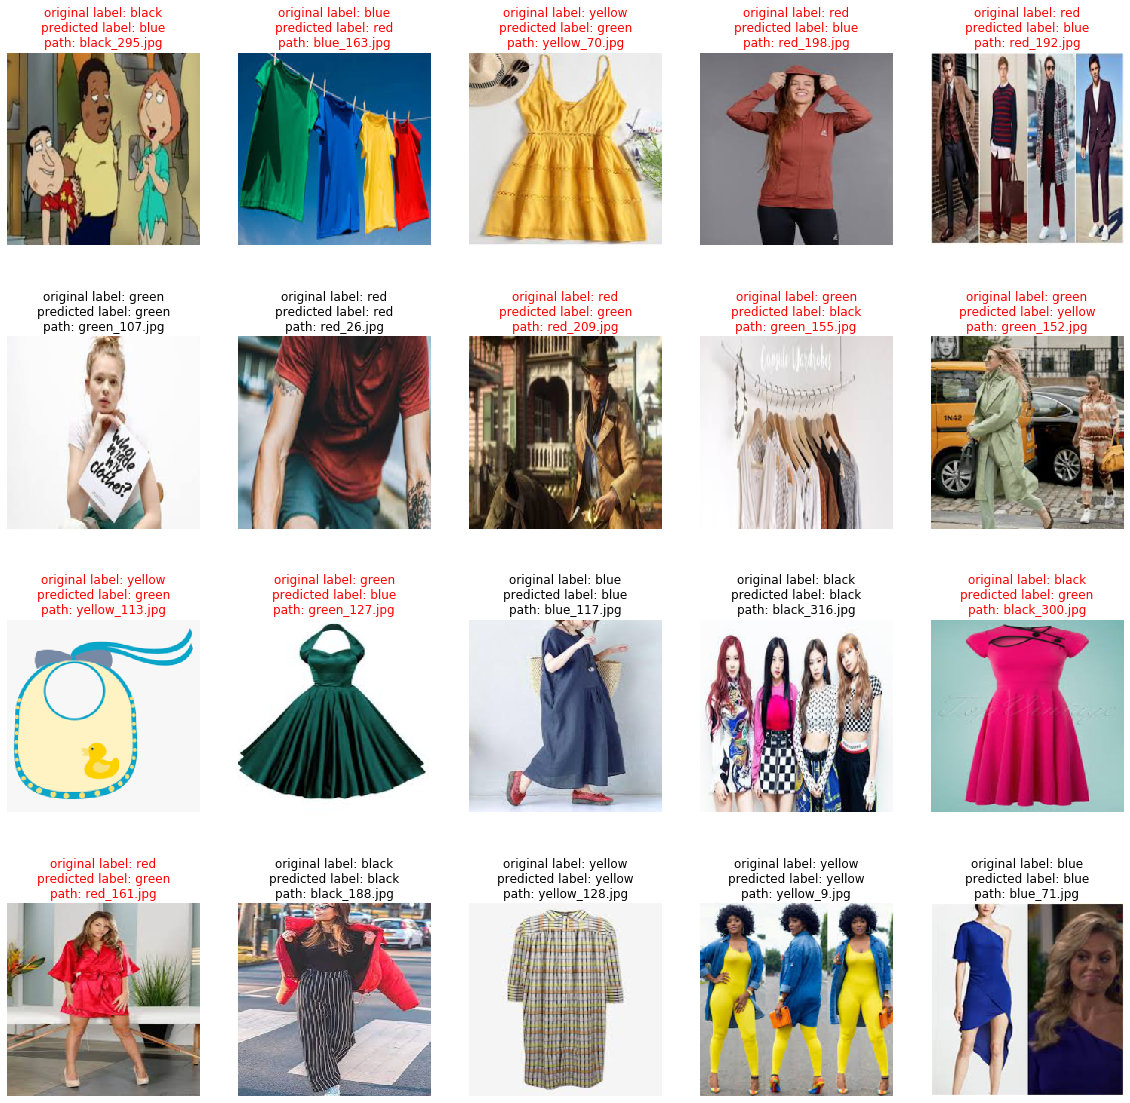

In [100]:
images_so_far = 0
num_images = 20 # batch_size is 64
figure, ax = plt.subplots(4, 5, figsize=(20, 20))

def imshowaxis(ax, img, orig, pred, path):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(f'original label: {orig}' + "\n" + f'predicted label: {pred}' + "\n" + f'path: ' + path, color="red", fontsize=12)
    else:
        ax.set_title(f'original label: {orig}' + "\n" + f'predicted label: {pred}' + "\n" + f'path: ' + path, fontsize=12)
    ax.axis("off")
    
    
for i in range(4):
    for j in range(5):
        if images_so_far < num_images:
                    imshowaxis(ax[i][j], img_least_prob_.cpu().data[images_so_far], CLASSES[labels_least_prob_[images_so_far]], CLASSES[preds_least_prob_[images_so_far]], path_[images_so_far].split('\\')[1] )
                    images_so_far += 1
        else:
            pass

In [101]:
images_to_delete = list( path_[z] for z in [0,1,4,5,7,8,9,10,13,14,17,19] )
images_to_delete[0]

'C:/Users/lasse/kaggleProjects/Farberkennung/data/train/black\\black_295.jpg'

In [102]:
for i in range(0,len(images_to_delete)):
    if os.path.exists(images_to_delete[i]):
        os.remove(images_to_delete[i])
    else:
        print(images_to_delete[i] + ": This file does not exist")